# Autoencoders

Goal: build a model that achieves a general "understanding" of the data within a latent variable framework. This understanding can be measured using variance explained and also behavior prediction accuracy score. Within a latent variable modeling framework, we assume thta the observed data $X$ is essentially low dimensional and it can be explained using a few latent variables $Z$.  Formally, this can be expressed as follows:

$$P(X) = \int P(X, Z) dZ = \int P(X | Z) P(Z) dZ,$$
where X is all observed modalities including neural activity and licking data.  We already have some validation and reasons to belive that this is a good assumption.  For example the LDA analysis showed us that we can obtain diverging trajectories in dimensions as low as 2, while maintaining discriminatory power.

If succesful, we can learn something about dimensionality of the data.  Also, hopefully we will be able to identify different sources of variation and see which of those are more correlated with the behavior.

## Architecture

So far, I have only experimented with the simplest possible model.  It includes the following layers:

### embedding layer

this layer takes data from different experiments and maps it to a space with shared dimensionality.  This is to circumvent the the mismatch in number of neurons in different experiments that was preventing us from mixing them together.  For example, if the hiddent shared dimension is 64, then the weights in this layer for experiment $i$ with $nc_i$ cells will have shape $nc_i \times 64$ and so on.  It has distinct weights for each experiment since they have different number of neurons and they are ordered arbitrarily.

What does this 64 dimensional space mean?  One way of looking at it is to assume there are some abstract patterns in neural population code that encode some specific event, and these events will be represented in a different way in each experiment.  One implicit assumption here is that such patterns are more or less present in different experiments, despite having different number of neurons from different subjects.  The goal of the embedding layer is to identify and encode such patterns.

### encoder network

Receives the output of embedding layer, now shared across experiments, as input.  Right now I'm using a single linear layer with 16 dimensions, followed by a nonlinearity.  This is an extremely limited choice.  There are lots of things one can try as an encoder network.  For example, one might add recurrence that captures evolving temporal patterns rather than instantanous patterns.  The 1-layer encoder right now is treating every timepoint as if they are identical, which is very wrong.


### decoder network

Just like encoder, this is also a 1-layer network followed by a nonlinearity.  Its output is fed into the transpose of the embedding layer, which aims to reconstruct the inputs.  The decoder also does not take into account time for now.

### Model sketch

Here is a high level illustration.  The key for a succesfull model will be a clever encoder and decoder design that respects the data structure and also temporal dynamics, both local and global scales. Decoding behavior labels and stim labels form latents will make them learn signals that are correlated to both, either one, or none of these labels (I will provide more details on this when I implemented it).

In [13]:
from IPython.display import IFrame
IFrame('./sketch.pdf', embed=True, width=700, height=500)

## Performance

Here I will load a sample autoencoder and plot how the latents look like.  This model has

- hidden shared dim = 64 (i.e. for embedding layer), and
- z_dim = 16 (latent dimension)

The variance explained is quite low, which is understandable given limitations of this architecture.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from datetime import datetime
from os.path import join as pjoin
from copy import deepcopy as dc
from tqdm.notebook import tqdm
import pickle
import h5py

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

os.environ["CUDA_VISIBLE_DEVICES"]="0"
github_path = pjoin(os.environ['HOME'], 'Dropbox/git/A1ToneDiscrimination/')
sys.path.insert(0, github_path)
from utils.plot_functions import *
from autoencoder.model_utils import print_num_params, to_np, load_model
from autoencoder.configuration import FeedForwardConfig, TrainConfig
from autoencoder.training import AETrainer, CLFTrainer

In [2]:
cm = 'tae_h:64_z:16_drp:0.1_wd:0.001_lr:0.01_gamma:0.95_latest'
mod, metadata = load_model(keyword=cm, chkpt_id=-1)
mod.config.base_dir

'/home/hadi/Documents/A1'

In [3]:
mod.config.base_dir = pjoin(os.environ['HOME'], 'Documents/A1')
mod.config.h_file = pjoin(os.environ['HOME'], 'Documents/A1/python_processed/organized_nb_std=1.h5')

In [4]:
trainer = AETrainer(mod, TrainConfig())

warning karl_2018-09-20
warning ken_2016-09-23
warning rodger_2017-08-22
warning scabbers_2016-08-24
warning scabbers_2016-09-07


In [5]:
metadata

{'model_name': 'tae_h:64_z:16_drp:0.1_wd:0.001_lr:0.01_gamma:0.95_latest_-9116718646930725274',
 'chkpt': 200}

In [6]:
output = trainer.validate()

valid loss: 72.112,   valid r2 score:  16.53 %


We can explain ~16% of variance

### Inspecting the model

Let us compare model predicted traces with the true data for the best and worst cells

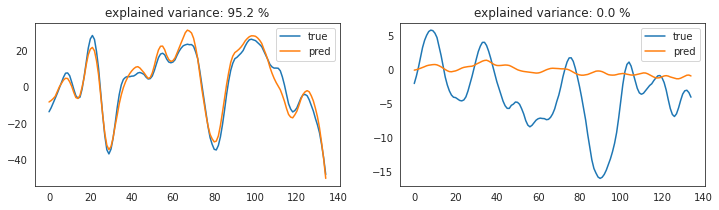

In [7]:
max_r2 = sorted([
    (x.max(), tr[:, np.argmax(x)], pr[:, np.argmax(x)])
    for x, tr, pr in zip(output['r2s'], output['trues'], output['preds'])],
    key=lambda tup: tup[0].max(), reverse=True,
)
min_r2 = sorted([
    (x.min(), tr[:, np.argmin(x)], pr[:, np.argmin(x)])
    for x, tr, pr in zip(output['r2s'], output['trues'], output['preds'])],
    key=lambda tup: tup[0].min(), reverse=False,
)

f, ax_arr = plt.subplots(1, 2, figsize=(12, 3))

r2, true, pred = max_r2[0]
ax_arr[0].plot(true, label='true')
ax_arr[0].plot(pred, label='pred')
ax_arr[0].set_title('explained variance: {:.1f} {:s}'.format(r2, '%'))
ax_arr[0].legend()

r2, true, pred = min_r2[0]
ax_arr[1].plot(true, label='true')
ax_arr[1].plot(pred, label='pred')
ax_arr[1].set_title('explained variance: {:.1f} {:s}'.format(r2, '%'))
ax_arr[1].legend()

plt.show()

### A big flaw:

The model predicts some cells perfectly, but other cells no better than chance.  I think I know why: if we look at the variance of the cell itself, we see that the one with almost perfect prediction has a large variance.  Why is this happening?  My guess is because this model is designed poorly and not properly constrained, it is choosing some high variance neurons and assigns some of the latent dimensions to just memorize that neuron.  This way, the model can achieve a lower mean-squared error.  I don't blame the model for showing this behavior.  Given the current setup, it is really constly to wrongly predict a high variacne neuron, but missing some low variance cells isn't as bad.

Possible solutions:

- normalize the loss using input variance. This way, the model will assign equal weight to different neurons and will learn a better latent code.  This isn't going to help us a lot, but i'm curious how this will affect the overall performance so will try this first
- then, the best strategy is to forget about this architecture and move on to a more constrained model which respects the temporal aspect of the data as well.  The fact that this simple autoencoder failed so badly means there is a nice challenge to address here. We can still use this model for benchmarking purposes.

In [8]:
r2, true, pred = max_r2[0]
msg1 = "best predicted neuron:\nr2 = {:.1f} {:s}\ntrace var: {:.2f}"
msg1 = msg1.format(r2, '%', true.var())

r2, true, pred = min_r2[0]
msg2 = "\nworst predicted neuron:\nr2 = {:.1f} {:s}\ntrace var: {:.2f}"
msg2 = msg2.format(r2, '%', true.var())

print(msg1)
print(msg2)

best predicted neuron:
r2 = 95.2 %
trace var: 302.02

worst predicted neuron:
r2 = 0.0 %
trace var: 24.34


This is really bad. A proper autoencoder should not learn to memorize the input data, but rather, detect patterns.

### Plotting the latents

let's just plot 5 of them and see how they look like (each corresponds to a single trial)

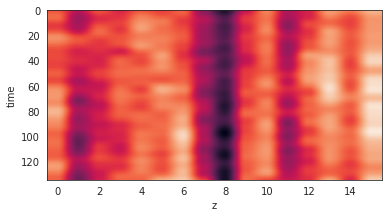

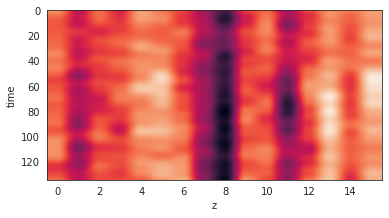

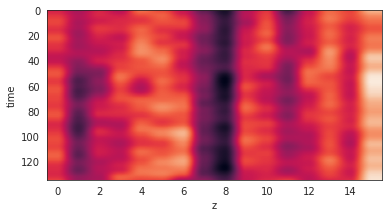

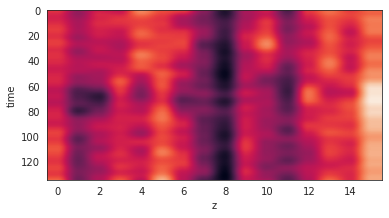

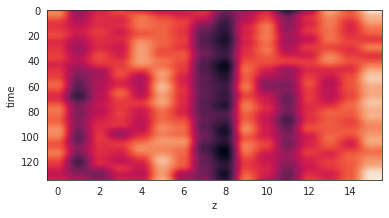

In [9]:
for i in range(5):
    plt.imshow(output['latents'][i], aspect=0.06)
    plt.ylabel('time')
    plt.xlabel('z')
    plt.show()

In [10]:
latents = np.concatenate([np.expand_dims(z, axis=0) for z in output['latents']])
latents.shape

(763, 135, 16)

In [11]:
labels = np.array(output['labels'])
labels.shape

(763,)

In [12]:
dict_list = []
for z, lbl in zip(output['latents'], output['labels']):
    nt, k = z.shape
    for i in range(k):
        data_dict = {
            'timepoint': range(nt),
            'label': [lbl] * nt,
            'dim': [i] * nt,
            'z': z[:, i],
        }
        dict_list.append(data_dict)

In [13]:
from utils.generic_utils import merge_dicts

df = pd.DataFrame.from_dict(merge_dicts(dict_list))
df.shape

(1648080, 4)

### Do latents look different for different trial types?

The resemble the traces obtained by simply averaging traces for different behavior types.  This is another sign that this model is not good, because it is expected to capture much more than this.

In [ ]:
sns.relplot(data=df, x='timepoint', y='z', col='label', hue='dim', kind="line")

In [ ]:
sns.relplot(data=df, x='timepoint', y='z', hue='label', col='dim', kind="line")